# Computer Vision Task

In [8]:
import requests
import os
from tqdm import tqdm
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import timm
from torchmetrics.classification import BinaryAUROC
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

In [2]:
os.makedirs("images/swimming-pool/yes")
os.makedirs("images/swimming-pool/no")

FileExistsError: [Errno 17] File exists: 'images/swimming-pool/yes'

In [3]:
def download_file(url, filename, verbose=True):
    try:
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        response.raise_for_status()  # Raises an HTTPError for bad responses
        
        with open(filename, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        
        if verbose:
            print(f"Downloaded: {filename}")
        return True
    
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return False

def download_file_parallel(args):
    """Wrapper function for multiprocessing - takes a tuple of (url, filename)"""
    url, filename = args
    return download_file(url, filename, verbose=False)

In [4]:
download_file("https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/images/swimming-pool/yes/manifest", "images/swimming-pool/yes/manifest")
download_file("https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/images/swimming-pool/no/manifest", "images/swimming-pool/no/manifest")

Downloaded: images/swimming-pool/yes/manifest
Downloaded: images/swimming-pool/no/manifest


True

In [ ]:
# Download 'yes' images in parallel
print("Downloading 'yes' images...")
base_url = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/images/swimming-pool/yes/"
download_args = []

with open("images/swimming-pool/yes/manifest", "r") as file:
    for line in file:
        filename = line.strip()
        filename = filename.split("/")[-1]
        url = base_url + filename
        local_path = f"images/swimming-pool/yes/{filename}"
        download_args.append((url, local_path))

# Download with 4 parallel processes
with Pool(processes=4) as pool:
    results = list(pool.map(download_file_parallel, download_args))

print(f"Successfully downloaded {sum(results)} out of {len(download_args)} 'yes' images")

KeyboardInterrupt: 

In [ ]:
# Download 'no' images in parallel
print("\nDownloading 'no' images...")
base_url = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/images/swimming-pool/no/"
download_args = []

with open("images/swimming-pool/no/manifest", "r") as file:
    for line in file:
        filename = line.strip()
        filename = filename.split("/")[-1]
        url = base_url + filename
        local_path = f"images/swimming-pool/no/{filename}"
        download_args.append((url, local_path))

# Download with 4 parallel processes
with Pool(processes=4) as pool:
    results = list(pool.map(download_file_parallel, download_args))

print(f"Successfully downloaded {sum(results)} out of {len(download_args)} 'no' images")

## Data Loader

In [2]:
class DataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = "images/swimming-pool/", batch_size: int = 32, img_size: int = 224):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            # transforms.RandomHorizontalFlip(0.5),
            # transforms.RandomVerticalFlip(0.5),
            # transforms.RandomRotation(30),
            # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
        ])

    def setup(self, stage=None):
        full = datasets.ImageFolder(os.path.join(self.data_dir, "train"), transform=self.transform)
        n = len(full)
        val_size = int(0.2 * n)
        train_size = n - val_size
        self.train_set, self.val_set = random_split(full, [train_size, val_size])
        self.test_set = datasets.ImageFolder(os.path.join(self.data_dir, "test"), transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=4)

In [3]:
class ScratchCNN(L.LightningModule):
    def __init__(self, lr=1e-3, pos_weight=1.0, img_size=224):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * (img_size//8)**2, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
        self.auroc = BinaryAUROC()

    def forward(self, x):
        return self.net(x).squeeze(1)

    def step(self, batch, stage):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        auc = self.auroc(preds, y.int())
        self.log(f"{stage}_loss", loss, prog_bar=True)
        self.log(f"{stage}_auc", auc, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self.step(batch, "val")

    def test_step(self, batch, batch_idx):
        self.step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

In [4]:
dm = DataModule(data_dir="images/swimming-pool/png", batch_size=64, img_size=224)


In [4]:
model = ScratchCNN(lr=1e-3, pos_weight=2000/4000, img_size=224)

checkpoint = ModelCheckpoint(monitor="val_auc", mode="max")
early_stop = EarlyStopping(monitor="val_auc", mode="max", patience=3)
tb_logger = TensorBoardLogger("logs")

trainer = Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    precision=16,
    callbacks=[checkpoint, early_stop],
)

trainer.fit(model, dm)
trainer.test(model, dm)

/home/claude/miniconda3/envs/coct/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | net     | Sequential        | 6.4 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | auroc   | BinaryAUROC       | 0      | train
------------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.785    Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 88/88 [01:25<00:00,  1.02it/s, v_num=7, train_loss=0.165, train_auc=0.968, val_loss=0.314, val_auc=0.896] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_auc            0.6499999761581421
        test_loss           0.6323252320289612
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6323252320289612, 'test_auc': 0.6499999761581421}]

In [5]:
class PretrainedCNN(ScratchCNN):
    def __init__(self, backbone_name="efficientnet_b0", lr=1e-4, pos_weight=1.0):
        super().__init__(lr=lr, pos_weight=pos_weight)
        # Override the feature extractor:
        self.net = timm.create_model(
            backbone_name, pretrained=True, num_classes=1
        )
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
        self.auc = BinaryAUROC()

In [6]:
model = PretrainedCNN(
    backbone_name="resnet34", 
    lr=3e-4, 
    pos_weight=2000/4000
)

checkpoint = ModelCheckpoint(monitor="val_auc", mode="max")
early_stop = EarlyStopping(monitor="val_auc", mode="max", patience=3)
tb_logger = TensorBoardLogger("logs")

trainer = Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    precision=16,
    callbacks=[checkpoint, early_stop],
)

trainer.fit(model, dm)
trainer.test(model, dm)

/home/claude/miniconda3/envs/coct/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | net     | ResNet            | 21.3 M | train
1 | loss_fn | BCEWithLogitsLoss | 0      | 

Epoch 4: 100%|██████████| 88/88 [01:26<00:00,  1.01it/s, v_num=12, train_loss=0.00211, train_auc=1.000, val_loss=0.150, val_auc=0.981]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_auc            0.8712500333786011
        test_loss           0.5022680163383484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5022680163383484, 'test_auc': 0.8712500333786011}]

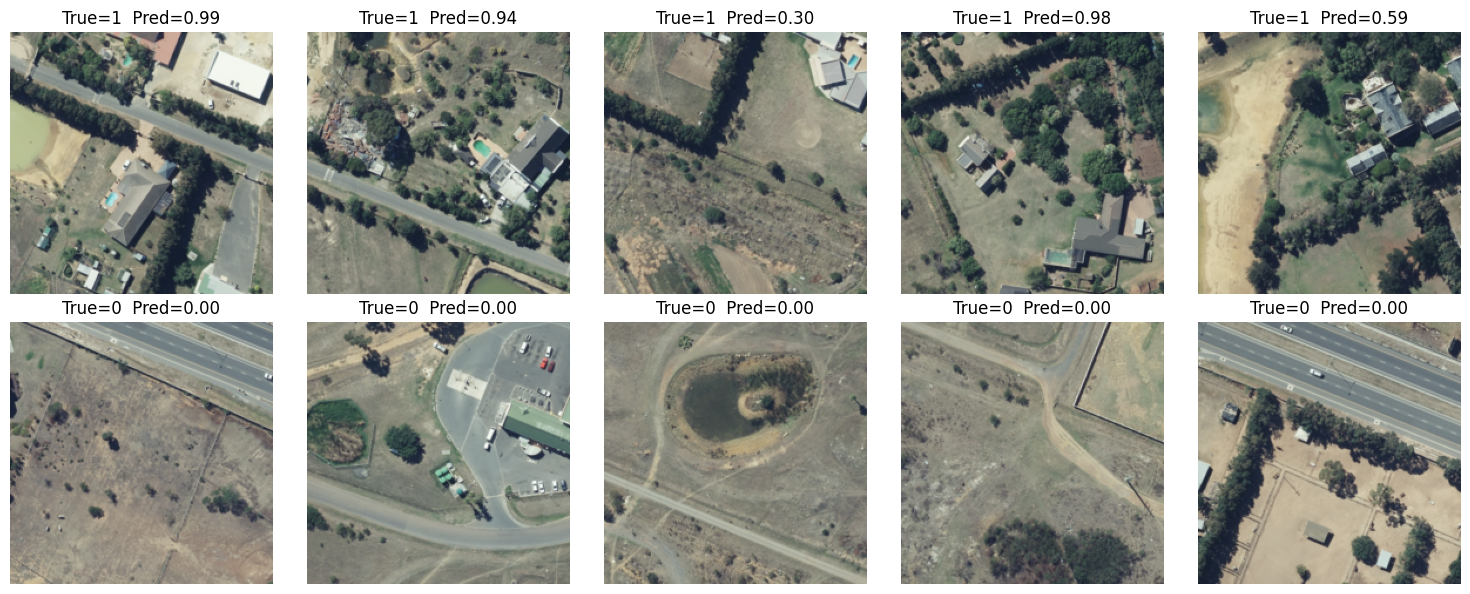

In [9]:
test_ds = dm.test_set  
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. find 5 positives and 5 negatives
pos_idxs, neg_idxs = [], []
for i, (_, label) in enumerate(test_ds):
    if   label == 1 and len(pos_idxs) < 5: pos_idxs.append(i)
    elif label == 0 and len(neg_idxs) < 5: neg_idxs.append(i)
    if len(pos_idxs) == 5 and len(neg_idxs) == 5:
        break
sample_idxs = pos_idxs + neg_idxs

# 3. helper to un-normalize a tensor image
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
def unnormalize(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1,2,0)
    img = img * std + mean
    return np.clip(img, 0, 1)

# 4. plot in a 2×5 grid
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for row, idxs in enumerate([pos_idxs, neg_idxs]):
    for col, idx in enumerate(idxs):
        img, label = test_ds[idx]
        x = img.unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(x)
            prob   = torch.sigmoid(logits)[0].item()

        ax = axes[row, col]
        ax.imshow(unnormalize(img))
        ax.set_title(f"True={label}  Pred={prob:.2f}")
        ax.axis("off")

plt.tight_layout()
plt.show()